In [1]:
import os
import sys

sys.path.append('..')

In [2]:
import azure.storage.blob
import dotenv
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import numpy as np

In [3]:
dotenv.load_dotenv()

True

In [4]:
from glance_utils import import_prep_glance_bolivia, get_class_timeseries, normalized_difference

# The complete time series

In [5]:
# load the glance data over Bolivia to get the land cover labels
gdf = import_prep_glance_bolivia()

In [6]:
container_client = azure.storage.blob.ContainerClient(
    "https://lcchallenge.blob.core.windows.net/",
    container_name="lc-challenge",
    credential=os.environ['SAS_TOKEN'],
)

# ZARR store with the time series extracted for the GLanCE bolivia points
store = zarr.ABSStore(client=container_client, prefix="merged_time_series.zarr")

Below we're opening the time series for all the GLanCE points in Bolivia. Some of them got duplicated (because they are are in the intersection between two footprints, we can deal with those later). As always, this is a lazy object and won't be read until you do so

They should still have x and y coordinates, but the best way to match them with their label is using the point_id dimension:

In [7]:
ds = xr.open_zarr(store)
ds

<xarray.Dataset>
Dimensions:   (time: 3838, point_id: 112179)
Coordinates:
  * point_id  (point_id) int32 578116 578114 578113 ... 621689 621680 621660
  * time      (time) datetime64[ns] 2000-01-01 ... 2000-03-14T14:07:11.097000
Data variables:
    blue      (time, point_id) float32 dask.array<chunksize=(3680, 10000), meta=np.ndarray>
    green     (time, point_id) float32 dask.array<chunksize=(3680, 10000), meta=np.ndarray>
    nir08     (time, point_id) float32 dask.array<chunksize=(3680, 10000), meta=np.ndarray>
    red       (time, point_id) float32 dask.array<chunksize=(3680, 10000), meta=np.ndarray>
    swir16    (time, point_id) float32 dask.array<chunksize=(3680, 10000), meta=np.ndarray>
    swir22    (time, point_id) float32 dask.array<chunksize=(3680, 10000), meta=np.ndarray>
    x         (point_id) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    y         (point_id) float64 dask.array<chunksize=(10000,), meta=np.ndarray>

drop duplicate points (where change is marked, the id is the same and they have different classes, here we drop them because the time series is the same!)

In [8]:
ds = ds.drop_duplicates(dim='point_id')

Scale to surface reflectance (currently it is in digital number)

In [9]:
ds = ds * 0.0000275 - 0.2

compute a couple of indices

In [10]:
ndvi = normalized_difference(ds, 'nir08', 'red').rename('ndvi')
nbr = normalized_difference(ds, 'nir08', 'swir16').rename('nbr')

In [11]:
nbr

<xarray.DataArray 'nbr' (time: 3838, point_id: 94945)>
dask.array<truediv, shape=(3838, 94945), dtype=float32, chunksize=(3680, 9800), chunktype=numpy.ndarray>
Coordinates:
  * point_id  (point_id) int32 578116 578114 578113 ... 554929 621696 621690
  * time      (time) datetime64[ns] 2000-01-01 ... 2000-03-14T14:07:11.097000

In [12]:
bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']

In [13]:
# get a list of the land cover classes at level1
lc_classes = gdf.Glance_Class_ID_level1.unique()

In [14]:
from tqdm.notebook import tqdm

Let's visualize a change point:

In [15]:
# let's visualize a point where change is happened
change = gdf[gdf.Change == 1].iloc[-10]

if we look below, we can see that it should be trees until 2013, and then 2016 onwards Herbaceous (not specified what it is in between)

In [16]:
gdf[gdf.ID == change.ID]

,Lat,Lon,Start_Year,End_Year,Dataset_Code,Continent_Code,LC_Confidence,Segment_Type,Leaf_Type,Impervious_Percent,...,Tree_Location,Veg_Modifier,Level1_Ecoregion,Level2_Ecoregion,Glance_Class_ID_level1,Glance_Class_ID_level2,Change,ID,Glance_ID,geometry
620516,-10.601825,-69.444122,2016,2018,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,66,66_00,Herbaceous,Grassland,True,577620,02_66_00_5_577620_2016_2018,POINT (-69.44412 -10.60182)
583781,-10.601825,-69.444122,1985,2013,5,South America,NaN,NaN,NaN,NaN,...,NaN,None,66,66_00,Trees,NaN,True,577620,02_66_00_5_577620_1985_2013,POINT (-69.44412 -10.60182)


In [17]:
import datetime

it's not super clear, there's some missing data in 2013 (between landsat 5 and landsat 8). But it would look like there's a change in the seasonal pattern and overall decrease in the NDVI trend around 2016.

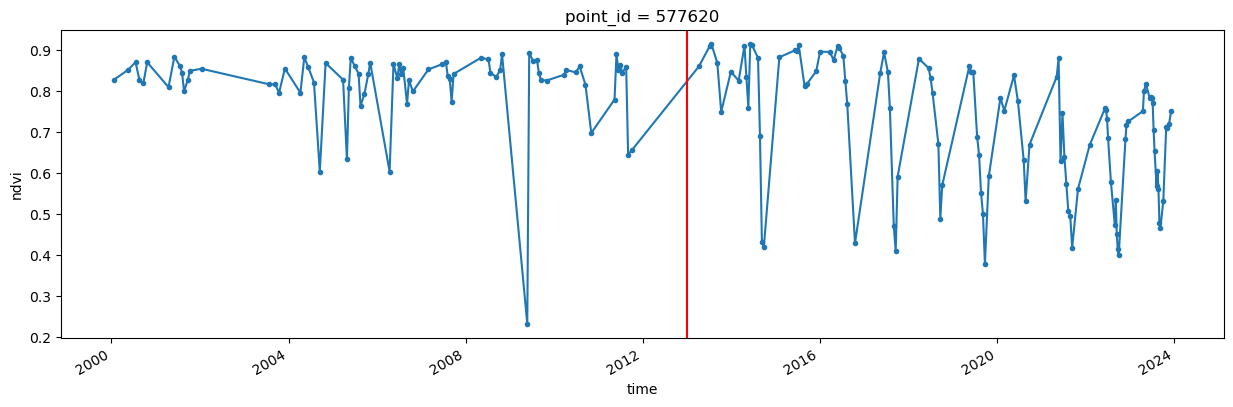

In [20]:
fig, ax = plt.subplots(1,1,figsize=(15,4))
ndvi.sel(point_id=change['ID']).dropna(dim='time').plot.line('.-', x='time',ax=ax)
ax.axvline(datetime.datetime(year=change['End_Year'], month=1, day=1), color='red')

now let's see some time series for 5 points in each class in the last two years or so

  0%|          | 0/6 [00:00<?, ?it/s]

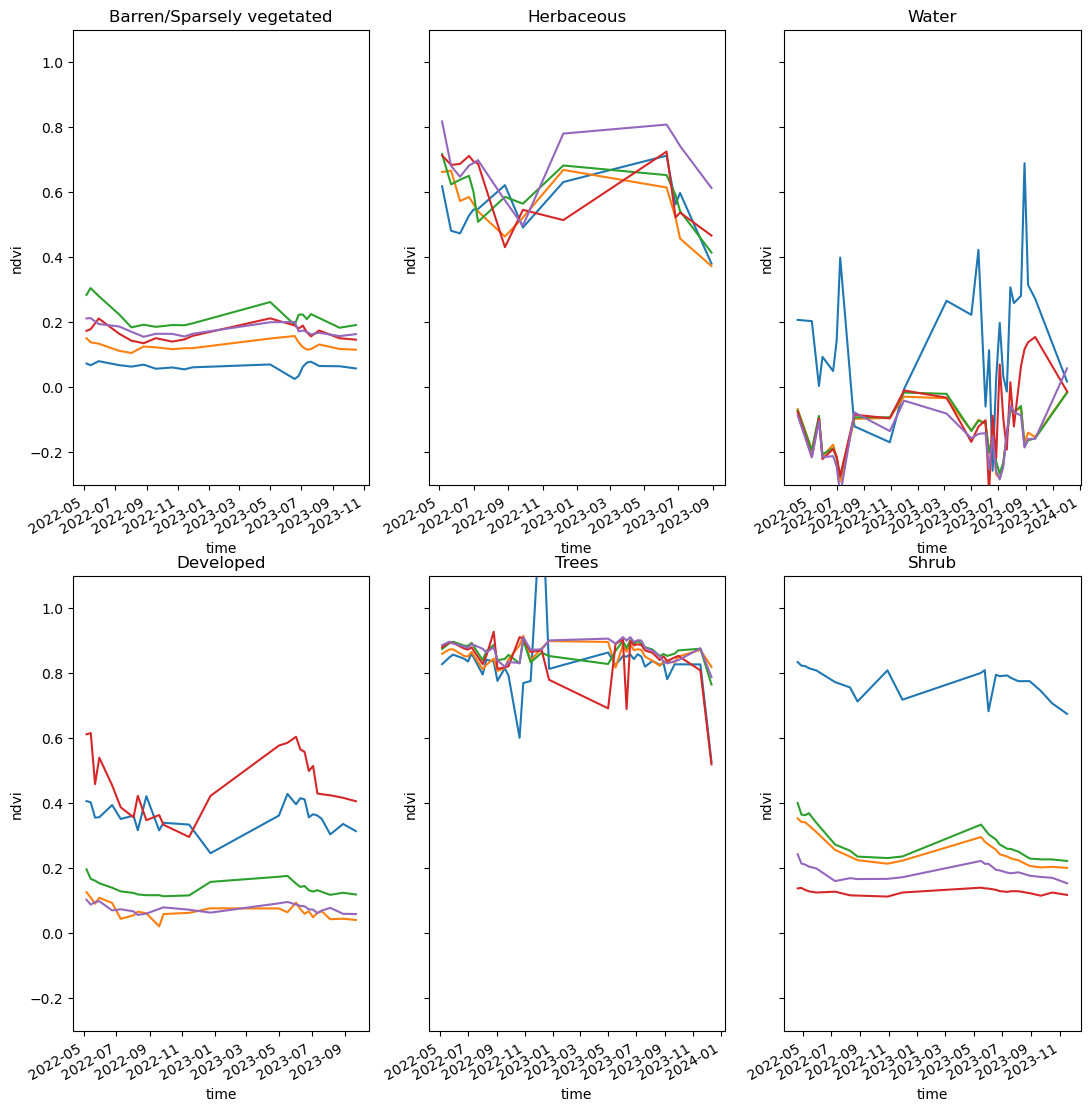

In [29]:
fig, ax = plt.subplots(2,3, figsize=(13, 13), sharey=True)
ax = ax.flatten()

for n, lc_class in tqdm(enumerate(lc_classes), total=len(lc_classes)):
    ndvi_class = get_class_timeseries(ndvi, gdf, lc_class)
    five_points = ndvi_class.isel(pid=slice(0,5)) # first 5 points
    last_years = five_points.isel(time=slice(-680, None)) # last 680 observations
     
    # plot 
    last_years.dropna(dim='time').plot.line('-', x='time', ax=ax[n])
    ax[n].get_legend().remove()
    ax[n].set_title(lc_class)
    ax[n].set_ylim(-0.3, 1.1)

plt.show()

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))
ax = ax.flatten()

for n, band in enumerate(bands):
    
    ds_forest[band].isel(pid=slice(None, 10)).dropna(dim='time').plot.line(ax=ax[n], x='time')